# Install Roboflow and Detectron2 Pip Packages, Import Deps

In [ ]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

# Download dataset via Roboflow pip package and show a sample annotation

In [10]:
VERSION = 1
rf = Roboflow(api_key="ZsZB2FnCmcNaslwIlejv")
project = rf.workspace("mydatasets-bqwxe").project("booksandcarssegmentation")
dataset = project.version(VERSION).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to BooksAndCarsSegmentation-1 in coco:: 100%|██████████| 98/98 [00:00<00:00, 321.98it/s]


In [14]:
register_coco_instances("booksncars_train", {}, f"/content/BooksAndCarsSegmentation-{VERSION}/train/_annotations.coco.json", f"/content/BooksAndCarsSegmentation-{VERSION}/train/")
register_coco_instances("booksncars_valid", {}, f"/content/BooksAndCarsSegmentation-{VERSION}/valid/_annotations.coco.json", f"/content/BooksAndCarsSegmentation-{VERSION}/valid/")
register_coco_instances("booksncars_test", {}, f"/content/BooksAndCarsSegmentation-{VERSION}/test/_annotations.coco.json", f"/content/BooksAndCarsSegmentation-{VERSION}/test/")

WARNING [04/27 13:37:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 13:37:12 d2.data.datasets.coco]: Loaded 78 images in COCO format from /content/BooksAndCarsSegmentation-1/train/_annotations.coco.json


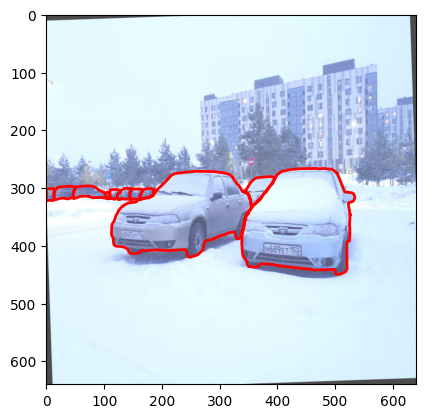

In [17]:
dataset_train = DatasetCatalog.get("booksncars_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

# Configure Detectron2 for fine tuning from COCO, Define training loop helper functions (from detectron2 repo), Run custom training loop

In [53]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("booksncars_train",) #Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("booksncars_test",) #Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000 # We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # books and cars!
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 # Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [54]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler, save_to_disk=True
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)
        
        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break
                
do_test(cfg, model)

[04/27 14:46:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [04/27 14:46:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 14:46:51 d2.data.datasets.coco]: Loaded 78 images in COCO format from /content/BooksAndCarsSegmentation-1/train/_annotations.coco.json
[04/27 14:46:51 d2.data.build]: Removed 0 images with no usable annotations. 78 images left.
[04/27 14:46:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/27 14:46:51 d2.data.build]: Using training sampler TrainingSampler
[04/27 14:46:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/27 14:46:51 d2.data.common]: Serializing 78 elements to byte tensors and concatenating them all ...
[04/27 14:46:51 d2.data.common]: Serialized dataset takes 0.31 MiB
[04/27 14:46:51 detectron2]: Starting training from ite

OrderedDict([('bbox',
              {'AP': 27.05993290479929,
               'AP50': 44.66510490334748,
               'AP75': 29.152754745917935,
               'APs': 0.0,
               'APm': 23.51448343592123,
               'APl': 41.338283828382835,
               'AP-books-and-cars': nan,
               'AP-book': 54.11986580959858,
               'AP-car': 0.0}),
             ('segm',
              {'AP': 32.8983528945166,
               'AP50': 44.66510490334748,
               'AP75': 39.984679861664326,
               'APs': 0.0,
               'APm': 30.84840732520457,
               'APl': 41.07260726072607,
               'AP-books-and-cars': nan,
               'AP-book': 65.7967057890332,
               'AP-car': 0.0})])

## mAP, Speed, Size

- **mAP:** 0.32898

- **mAP50:** 0.44665

- **Speed of inference:** 146.42 ms

- **Model Size:** 170 MB

In [ ]:
"""
[04/27 15:05:22 d2.evaluation.evaluator]: Total inference time: 0:00:00.146420 (0.146420 s / iter per device, on 1 devices)

...

[04/27 15:05:22 d2.evaluation.coco_evaluation]: Evaluation results for segm: 
|   AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:------:|:------:|:------:|:-----:|:------:|:------:|
| 32.898 | 44.665 | 39.985 | 0.000 | 30.848 | 41.073 |
[04/27 15:05:22 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category       | AP   | category   | AP     | category   | AP    |
|:---------------|:-----|:-----------|:-------|:-----------|:------|
| books-and-cars | nan  | book       | 65.797 | car        | 0.000 |
"""

Possible reasons for Cars class zero mAP:

1. Class imbalance:

|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| books-cars | 0            |    book    | 470          |    car     | 282          |
|            |              |            |              |            |              |
|   total    | 752          |            |              |            |              |

2. Poor Dataset Quality:

In the original dataset, there are 94 bboxes with cars (which were augmented to 282 samples, as you see in the table above). Among these 94 examples, there are plenty of ways a car was captured at the photo: side, back, front, diagonally, from afar, from near. Such variability together with lack of data could lead to poor performance within the limited number of epochs.

The books case is much easier: all of them were captured from approximately same distance and angle. Moreover, there are more books samples in the dataset. So, the model has managed to converge well during the training process. The resulted `mAP` for the books class is 0.66.